<a href="https://colab.research.google.com/github/NicoPP1/PDI/blob/main/TP7/TP7Parma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo práctico Nº7 Procesamiento Digital de Imágenes - PROCESAMIENTO MORFOLÓGICO
### Autor: Nicolás Daniel Parma Paternostro
### Consigna: 

Desarrollar un aplicativo que permita abrir una imagen y automáticamente convertirla a niveles de grises (en caso de no estarlo) y visualizarla. Con esta imagen se aplicarán los siguientes filtros morfológicos, los cuales deben poderse seleccionar de una lista:

- Erosión (tomar el mínimo valor de luminancia de la vecindad).
- Dilatación (máximo)
- Apertura
-Cierre
- Borde morfológico (frontera interna y externa)
- Mediana
- Top-hat

El elemento estructurante será de una ventana de 3x3 pixeles.

El aplicativo debe incluir una función de copiado de la imagen procesada, de tal manera que esta pueda tomarse como imagen de entrada para así poder aplicar dos o más filtros en secuencia.

El resultado del filtro debe poder guardarse como una nueva imagen en nivel de grises.

Adicionalmente se debe mostrar un plot con el resultado respectivo para cada uno de los filtros indicados.

Nota: La función que desarrollaron para la convolución es la misma que pueden usar para recorrer toda la imagen y aplicar el filtro morfológico.

## FECHA DE ENTREGA: 26 DE NOVIEMBRE

##Subir la imagen IC2 adjunta en el formulario de Google

###Librerias

In [1]:
import imageio
import numpy as np
import matplotlib.pyplot as plt

###Funciones para trabajar en los espacios RGB e YIQ

In [2]:
#Función para clipear la luminancia
def clipY(mat):
    mat = np.clip(mat,0.0,1.0)
    return mat

#Función para clipear la componente en fase
def clipI(mat):
    mat = np.clip(mat,-0.5957,0.5957)          
    return mat

#Función para clipear la el componente en cuadratura
def clipQ(mat):
    mat = np.clip(mat,-0.5226,0.5226)          
    return mat

#Función para obtener componentes RGB de una imagen y devolverlo en el espacio YIQ
def RGB2YIQ(img):
    img = img.astype(float) #Cambio tipo de dato para trabajar en float
    r,g,b = RGB(img)
    r = r/255 #normalizo canales
    g = g/255 #normalizo canales
    b = b/255 #normalizo canales

    Y = (r*0.299+g*0.587+b*0.114)
    I = (r*0.595716-g*0.274453-b*0.321263)
    Q = (r*0.211456-g*0.522591+b*0.311135)

    return(Y,I,Q)

#Función para obtener los canales RGB de una imagen
def RGB(img):
    img = img.astype(float) #Cambio tipo de dato para trabajar en float
    r = img[:,:,0]
    g = img[:,:,1]
    b = img[:,:,2]
    return r,g,b

#Función para obtener una imagen RGB a partir de los componentes YIQ modificadas
def YIQ2RGB(Y,I,Q):
    Y = clipY(Y) #función para clipear luminancia
    I = clipI(I) #función para clipear luminancia
    Q = clipQ(Q) #función para clipear luminancia

    dimension = Y.shape

    r = np.zeros((dimension[0],dimension[1]), dtype = float)
    g = np.zeros((dimension[0],dimension[1]), dtype = float)
    b = np.zeros((dimension[0],dimension[1]), dtype = float)

    r = (Y+0.9563*I+0.621*Q)*255
    g = (Y-0.2721*I-0.6474*Q)*255
    b = (Y-1.1070*I+1.7046*Q)*255

    r = np.clip(r,0,255)
    g = np.clip(g,0,255)
    b = np.clip(b,0,255)

    img = np.zeros((dimension[0],dimension[1],3),dtype = 'uint8') #Transformo a tipo de dato uint8 ya que es el requerido para mostrar las imágenes
    img[:,:,0] = r
    img[:,:,1] = g
    img[:,:,2] = b

    return(img)

### Función para cargar el kernel para realizar el filtrado por convolución (se utiliza el filtro laplaciano para comparar resultados de las distintas operaciones morfológicas)

In [3]:
def cargaKernels(k):
    if k == "plano3":
        kernel = (1/9)*np.ones((3,3))
    elif k == "plano5":
        kernel = (1/25)*np.ones((5,5), dtype = 'float64')
    elif k == "plano7":
        kernel = (1/49)*np.ones((7,7))

    elif k == "bartlett3":
        kernel  = (1/16)*np.matrix('1 2 1; 2 4 2; 1 2 1')
    elif k == "bartlett5":
        kernel = (1/81)*np.matrix('1 2 3 2 1 ; 2 4 6 4 2; 3 6 9 6 3; 2 4 6 4 2 ; 1 2 3 2 1')
    elif k == "bartlett7":
        kernel = (1/256)*np.matrix('1 2 3 4 3 2 1; 2 4 6 8 6 4 2; 3 6 9 12 9 6 3; 4 8 12 16 12 8 4; 3 6 9 12 9 6 3; 1 2 3 4 3 2 1; 2 4 6 8 6 4 2')

    elif k == "gaussiano5":
        kernel = (1/256)*np.matrix('1 4 6 4 1; 4 16 24 16 4; 6 24 36 24 6; 4 16 24 16 4; 1 4 6 4 1')
    elif k == "gaussiano7":
        kernel = (1/4096)*np.matrix('1 6 15 20 15 6 1; 6 36 90 120 90 36 6; 15 90 225 300 225 90 15; 20 120 300 400 300 120 20; 15 90 225 300 225 90 15; 6 36 90 120 90 36 6; 1 6 15 20 15 6 1')
   
    elif k == "laplacianov4":
        kernel = np.matrix('0 -1 0; -1 4 -1; 0 -1 0')
    elif k == "laplacianov8":
        kernel = np.matrix('-1 -1 -1; -1 8 -1; -1 -1 -1')

    elif k == "sobelN":
        kernel = np.matrix('-1 -2 -1; 0 0 0; 1 2 1')
    elif k == "sobelNE":
        kernel = np.matrix('0 -1 -2; 1 0 -1; 2 1 0')
    elif k == "sobelE":
        kernel = np.matrix('1 0 -1; 2 0 -2; 1 0 -1')
    elif k == "sobelSE":
        kernel = np.matrix('2 1 0;1 0 -1; 0 -1 -2')

    elif k == "sobelS":
        kernel = np.matrix('1 2 1; 0 0 0; -1 -2 -1')
    elif k == "sobelSW":
        kernel = np.matrix('0 1 2; -1 0 1; -2 -1 0')
    elif k == "sobelW":
        kernel = np.matrix('-1 0 1;-2 0 2; -1 0 1')
    elif k == "sobelNW":
        kernel = np.matrix('-2 -1 0;-1 0 1; 0 1 2')
    elif k == "pasaaltos02":
        kernel = np.matrix('1 -4 6 -4 1; -4 16 -24 16 -4; 6 -24 36 -24 6; -4 16 -24 16 -4; 1 -4 6 -4 1')
    elif k == "pasaaltos04":
        kernel = np.matrix('1 4 -10 4 1;4 16 -40 16 4;-10 -40 100 -40 -10; 4 16 -40 16 4;1 4 -10 4 1')
    elif k == "pasabanda":
        kernel = np.matrix('1 0 -2 0 1; 0 0 0 0 0; -2 0 4 0 -2; 0 0 0 0 0 ; 1 0 -2 0 1')  
  
    return kernel

### Función para realizar la convolución a partir de la luminancia de una imagen y el kernel de un filtro deseado


In [4]:
def convo(Y,kernel):
    shapeY = Y.shape
    heightY = shapeY[0]
    widthY = shapeY[1]


    shapeKernel = kernel.shape
    heightKernel = shapeKernel[0]
    widthKernel = shapeKernel[1]

    Yconv = np.zeros((heightY,widthY))

    #Según el tamaño del kernel, es distinto el padding de ceros a realizar
    if kernel.shape[0] == 3:
        Ypad = np.zeros((heightY+2,widthY+2))
        Ypad[1:heightY+1,1:widthY+1] = Y
        
        for i in range(heightY):
            for j in range(widthY):
                Yconv[i,j] = np.sum(np.multiply(Ypad[i:i+heightKernel,j:j+widthKernel],kernel))

                
        Yconv = np.clip(Yconv,0,1)

        
    elif kernel.shape[0] == 5:
        Ypad = np.zeros((heightY+4,widthY+4))
        Ypad[2:heightY+2,2:widthY+2] = Y
        
        for i in range(heightY):
            for j in range(widthY):
                Yconv[i,j] = np.sum(np.multiply(Ypad[i:i+heightKernel,j:j+widthKernel],kernel))
                
        Yconv = np.clip(Yconv,0,1)

        
        
    elif kernel.shape[0] == 7:
        Ypad = np.zeros((heightY+6,widthY+6))
        Ypad[3:heightY+3,3:widthY+3] = Y
        
        for i in range(heightY):
            for j in range(widthY):
                Yconv[i,j] = np.sum(np.multiply(Ypad[i:i+heightKernel,j:j+widthKernel],kernel))
                
        Yconv = np.clip(Yconv,0,1)
        
    else:
        print('filtro de orden incorrecto')

    return Yconv

### Implementación de las distintas operaciones morfológicas

In [5]:
# El parámetro Y utilizado en las funciones es la matriz con padding, de manera tal
# que al realizar i:i+3 el resultado se asigna al pixel central de la matriz sin
# realizar el padding.

def dilatation(Y):
    Ydil = np.zeros((heightY,widthY))

    for i in range(heightY):
        for j in range(widthY):
            Ydil[i,j] = np.amax(Y[i:i+heightSE,j:j+widthSE])
            
    Ydil = np.clip(Ydil,0,1)
    return Ydil

def erosion(Y):
    Yer = np.zeros((heightY,widthY))
    
    for i in range(heightY):
        for j in range(widthY):
            Yer[i,j] = np.amin(Y[i:i+heightSE,j:j+widthSE])
            
    Yer = np.clip(Yer,0,1)
    return Yer

def median(Y):
    Ymed = np.zeros((heightY,widthY))
    
    for i in range(heightY):
        for j in range(widthY):
            Ymed[i,j] = np.median(Y[i:i+heightSE,j:j+widthSE])
            
    Ymed = np.clip(Ymed,0,1)
    return Ymed

### Aplicativo que permite seleccionar la imagen de un circuito integrado (IC o IC2) o de un fondo de ojo y seleccionar la operación a aplicar. Se puede descargar la imagen obtenida al aplicar el filtro presionando el botón "descargar imagen", la misma se guarda como img.jpg. 

### Si se desea aplicar operaciones en cascada, se debe elegir primero alguna de las tres imágenes disponibles, seleccionar la operacion a realizar, presionar el botón aplicar operación, descargar la imagen con el botón correspondiente y luego seleccionar desde el menú desplegable "Imagen descargada" para aplicar la operación a la imagen modificada, previamente seleccionado la operación deseada y luego apretando el botón aplicar operación.

Button(description='aplicar operacion', style=ButtonStyle())

Button(description='descargar imagen', style=ButtonStyle())

Aplicar Cierre a Imagen descargada
Aplicado


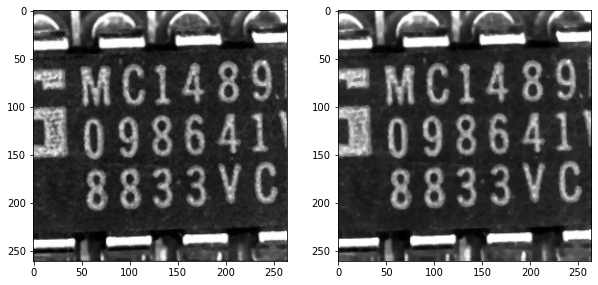

In [12]:
import ipywidgets as widgets
from IPython.display import display

aplicar = widgets.Button(description = "aplicar operacion")
descarga = widgets.Button(description = "descargar imagen")
#@title Ingrese la URL de la imagen deseada y luego seleccione el filtro a realizar { run: "auto", vertical-output: true }

u = "Imagen descargada" #@param ["IC", "IC2", "Fondo de ojo", "Imagen descargada"]
if u == "IC":
    url = "https://www.electan.com/images/Sparkfun/11107-01.jpg"
elif u == "Fondo de ojo":
    url = "https://www.rahhal.com/blog/wp-content/uploads/2015/07/fondo-ojo-normal.jpg"
elif u == "Imagen descargada":
    url = "/content/img.jpg"
elif u == "IC2":
    url = "/content/IC2.png"

img = imageio.imread(url)

opMorph = "Cierre" #@param ["Erosion", "Dilatacion", "Apertura", "Cierre", "Borde interno", "Borde externo", "Mediana", "Top-hat"]
Y,I,Q = RGB2YIQ(img)

structurantElement = np.ones((3,3))

shapeY = Y.shape
heightY = shapeY[0]
widthY = shapeY[1]

shapeSE = structurantElement.shape
heightSE = shapeSE[0]
widthSE = shapeSE[1]

Ypad = np.zeros((heightY+2,widthY+2))
Ypad[1:heightY+1,1:widthY+1] = Y

def on_aplicar_clicked(b):
    print(f"Aplicar {opMorph} a {u}")

    global YopMorph
    YopMorph = np.zeros((heightY,widthY))

    if opMorph == 'Erosion':
        YopMorph = erosion(Ypad)
    elif opMorph == 'Dilatacion':
        YopMorph = dilatation(Ypad)
    elif opMorph == 'Apertura':
        YopMorph = dilatation(erosion(Ypad))
    elif opMorph == 'Cierre':
        YopMorph = erosion(dilatation(Ypad))
    elif opMorph == 'Borde interno':
        YopMorph = Y-erosion(Y)
        YopMorph = np.clip(YopMorph,0,1)
    elif opMorph == 'Borde externo':
        YopMorph = dilatation(Y)-Y
        YopMorph = np.clip(YopMorph,0,1)
    elif opMorph == 'Mediana':
        YopMorph = median(Ypad)
    elif opMorph == 'Top-hat':
        YopMorph = Y-dilatation(erosion(Ypad))
        YopMorph = np.clip(YopMorph,0,1)

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(10, 20)

    ax[0].imshow(Y,'gray')
    ax[1].imshow(YopMorph,'gray')
    print("Aplicado")

def on_descarga_clicked(b):
    plt.imsave('/content/img.jpg',YopMorph,cmap = 'gray')
    plt.imshow(YopMorph,cmap = 'gray')
    print("Descarga realizada correctamente")

    
aplicar.on_click(on_aplicar_clicked)
descarga.on_click(on_descarga_clicked)

display(aplicar,descarga)

### Aplico todos los filtros a la imagen anterior para poder visualizar los efectos de cada filtro en particular sobre la imagen

In [13]:
Yer = erosion(Ypad)

Ydil = dilatation(Ypad)

Yap = dilatation(erosion(Ypad))

Ycl = erosion(dilatation(Ypad))

Yext = Ydil-Y
Yext = np.clip(Yext,0,1)

Yint = Y-Yer
Yint = np.clip(Yint,0,1)

Ymed = median(Ypad)

YTH = Y-Yap
YTH = np.clip(YTH,0,1)

Ylap8 =  convo(Y,cargaKernels('laplacianov8'))
Ylap8er = convo(Yer,cargaKernels('laplacianov8'))
Ylap8dil = convo(Ydil,cargaKernels('laplacianov8'))
Ylap8ap = convo(Yap,cargaKernels('laplacianov8'))
Ylap8cl = convo(Ycl,cargaKernels('laplacianov8'))
Ylap8med = convo(Ymed,cargaKernels('laplacianov8'))

### Visualización de las distintas operaciones

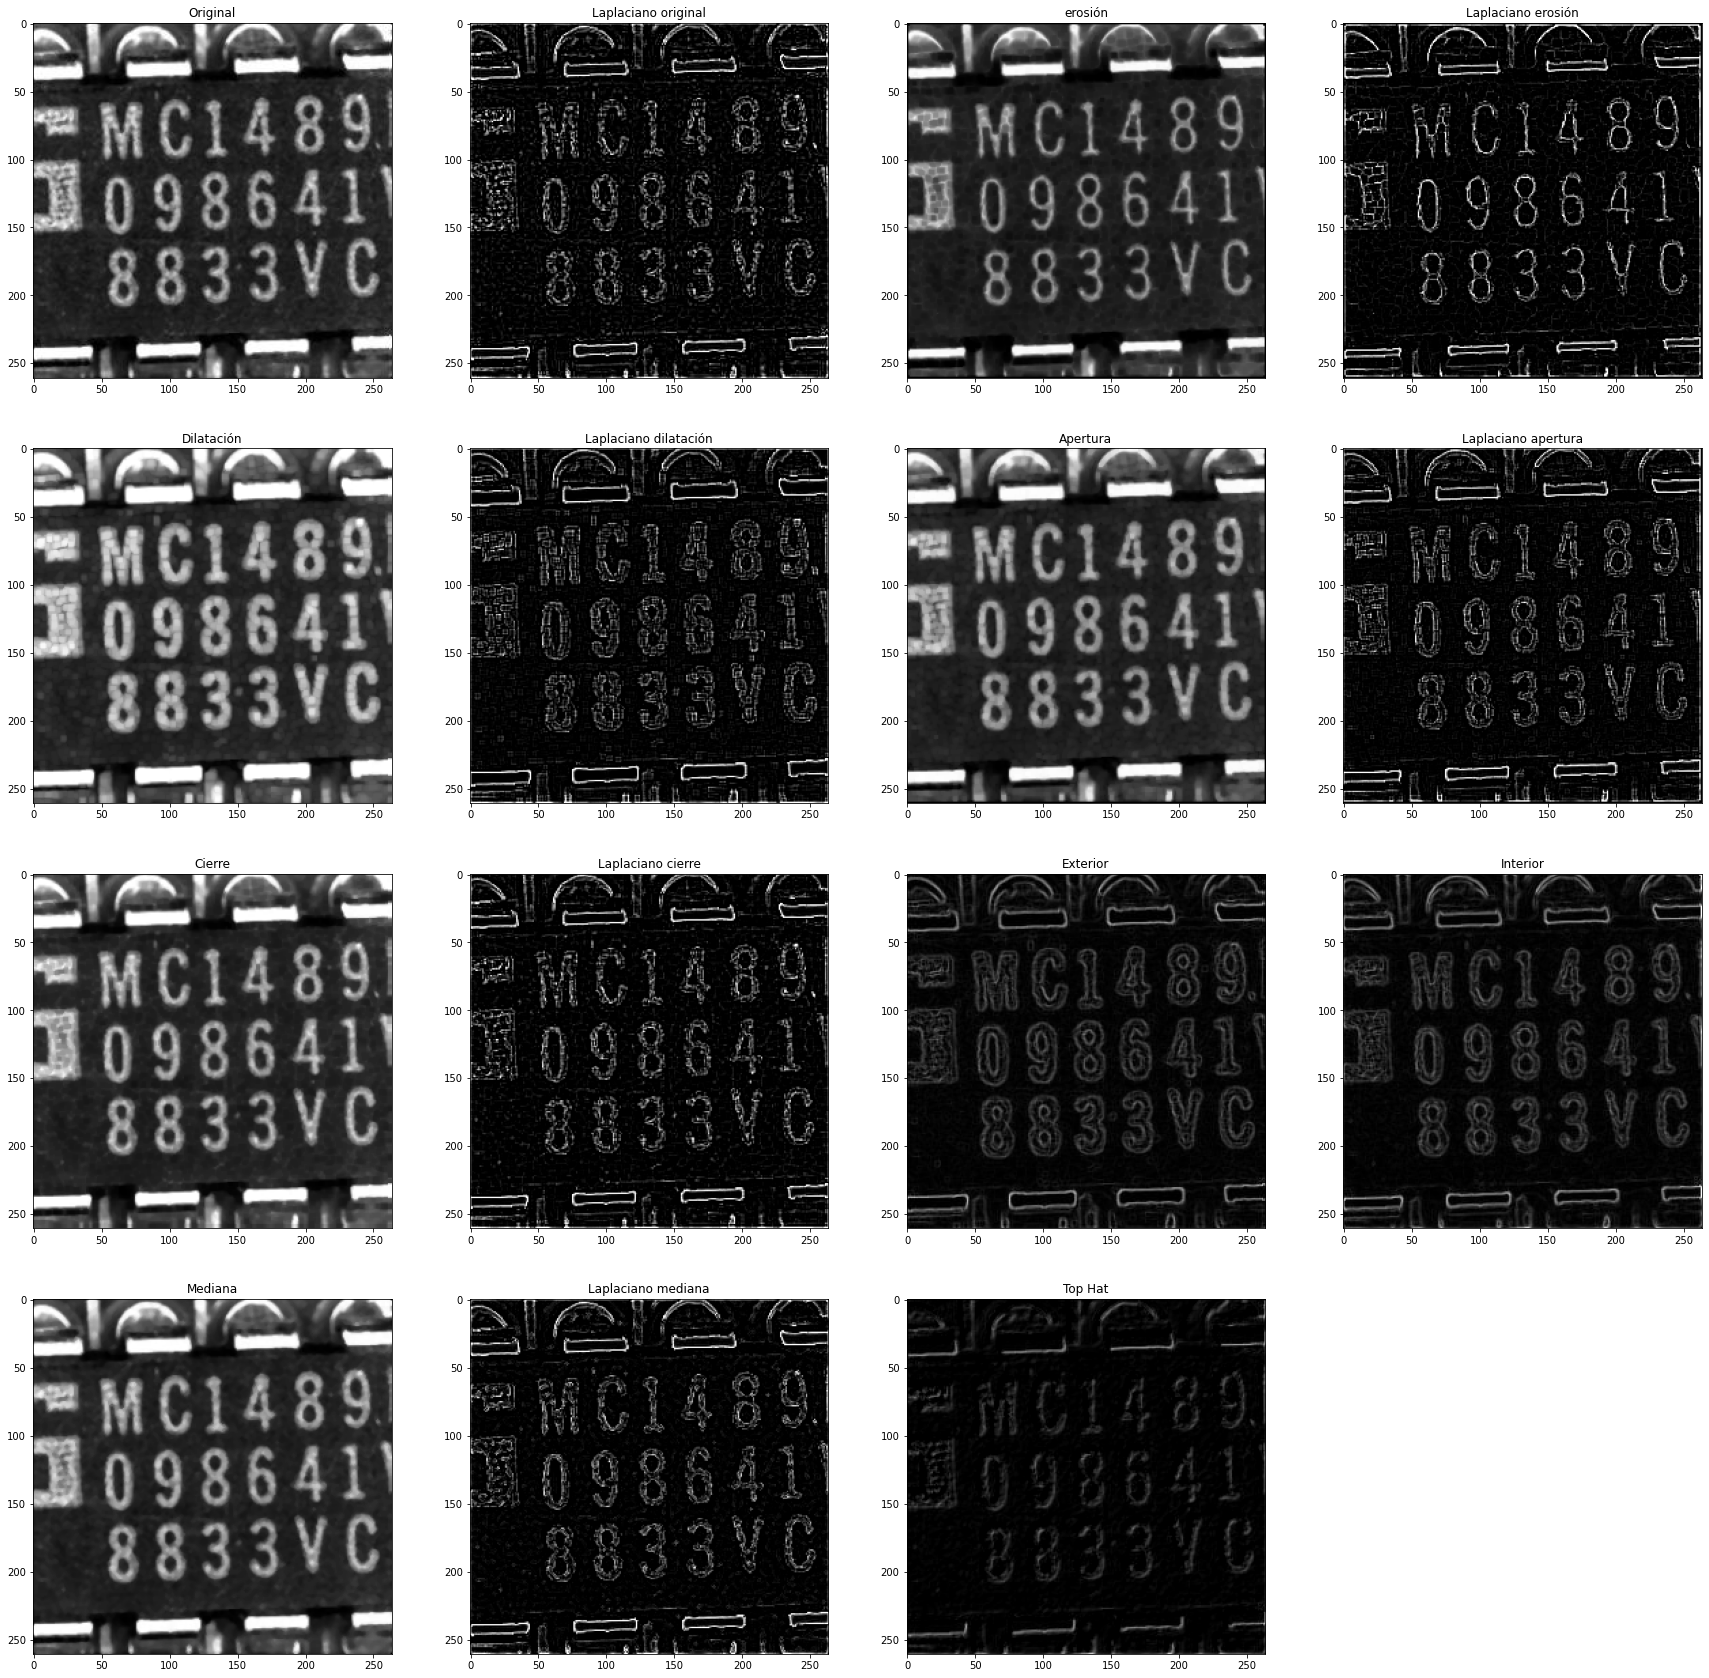

In [14]:
fig,ax = plt.subplots(4,4)
fig.set_size_inches(30,30)

ax[0,0].imshow(Y,'gray')
ax[0,0].set_title('Original')
ax[0,1].imshow(Ylap8,'gray')
ax[0,1].set_title('Laplaciano original')
ax[0,2].imshow(Yer,'gray')
ax[0,2].set_title('erosión')
ax[0,3].imshow(Ylap8er,'gray')
ax[0,3].set_title('Laplaciano erosión')

ax[1,0].imshow(Ydil,'gray')
ax[1,0].set_title('Dilatación')
ax[1,1].imshow(Ylap8dil,'gray')
ax[1,1].set_title('Laplaciano dilatación')
ax[1,2].imshow(Yap,'gray')
ax[1,2].set_title('Apertura')
ax[1,3].imshow(Ylap8ap,'gray')
ax[1,3].set_title('Laplaciano apertura')

ax[2,0].imshow(Ycl,'gray')
ax[2,0].set_title('Cierre')
ax[2,1].imshow(Ylap8cl,'gray')
ax[2,1].set_title('Laplaciano cierre')
ax[2,2].imshow(Yext,'gray')
ax[2,2].set_title('Exterior')
ax[2,3].imshow(Yint,'gray')
ax[2,3].set_title('Interior')

ax[3,0].imshow(Ymed,'gray')
ax[3,0].set_title('Mediana')
ax[3,1].imshow(Ylap8med,'gray')
ax[3,1].set_title('Laplaciano mediana')
ax[3,2].imshow(YTH,'gray')
ax[3,2].set_title('Top Hat')

fig.delaxes(ax[3,3])

# Análisis de resultados


En el presente trabajo se pudo implementar correctamente a partir de una imagen RGB y obteniendo su luminancia las siguientes operaciones morfológicas

- Erosión (mínimo valor de luminancia de la vecindad).
- Dilatación (máximo valor de luminancia de la vecindad)
- Apertura (erosión seguida por dilatación)
- Cierre (dilatación seguido por erosión)
- Borde exterior (dilatación menos original)
- Borde interior (original menos erosión)
- Mediana
- Top-hat (original menos apertura)

Observando las distintas operaciones morfológicas con respecto a la imagen original se observa lo siguiente:

- Para el caso de la operación de erosión, se observar una anogastamiento en los bordes de las letras y números, ocasionado por tomar el mínimo valor en un área de 3x3 píxeles.

- En cuanto a la dilatación, se puede ver un claro ensanchamiento en los caracteres 

- Para la operación de apertura, se observa una mayor definición en los bordes qeu para el caso de la imagen original, con una tendencia a eliminar los segmentos finos de la imagen (observar borde lateral derecho, se elimina la presencia de la linea blanca existente en la imagen original)

- Con respecto a la operación de cierre, se obtiene un resultado similar a la operación de apertura, pero conservando los elementos finos de la imagen

- Para el caso de la operación de borde exterior, se tiende a obtener la frontera exterior de los caracteres. Sim embargo, debido a la baja resolución y definición de la imagen, la misma no es completamente correcta. Sin embargo, gracias al aplicativo desarrollado que permite aplicar operaciones en cascada, si se aplica primero la mediana y luego la operación de borde exterior se obtiene la siguiente imagen donde se observa una mejor obtención de los bordes exteriores de los caracteres

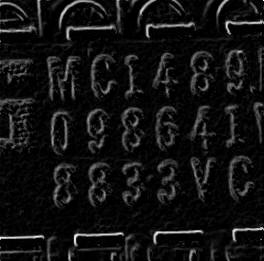


- En cuanto a la operación de borde interior ocurre un fenómeno muy similar al del borde exterior, pero para las fronteras internas de los caracteres. Aplicando la mediana y luego la operación de frontera interna se obtiene el siguiente resultado

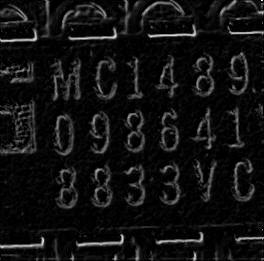



- Para la operación de mediana se obtiene una imagen más definida que la original, lo cual es lo esperado para este tipo de filtrado que realiza un promedio de los pixeles adyacentes.

- Por último, con respecto a la operación Top-hat, se espera obtener los elementos más pequeños y más brillantes que su entorno, como lo son los caracteres del circuito integrado y sus pines, resultado que se obtiene al realizar dicha operación.


Además, se observa una clara mejora en la detección de bordes utilizando el filtrado por convolución con el kernel del filtro laplaciano vecino 8 para los casos de las operaciones de erosión, apertura, cierre y mediana. Obteniendo también un resultado óptimo para el caso de las operaciones de borde exterior e interior a la imagen luego de realizar la operación de mediana.

Por último, se llega a la conclusión de que aplicar varias operaciones en cascada acentúa los efectos de las mismas. Esto es deseable aplicar para imágenes de alta resolución, ya que la ventana estructurante es relativamente pequeña (9 píxeles en total).